<a href="https://colab.research.google.com/github/cedric-bit/Geospatial-Data-Science-2023/blob/main/loadDATA509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install folium



In [ ]:
!pip install gtfs-realtime-bindings


In [ ]:
!pip install osmnx







In [ ]:
!pip install --upgrade protobuf



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dossier geospacialdata trouvé: /content/drive/MyDrive/Geospatial Data Science 2023
Contenu du premier fichier:


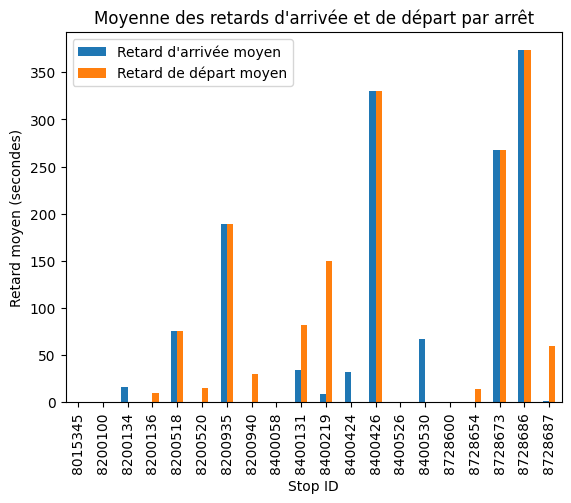

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
from datetime import datetime
import osmnx as ox
from google.transit import gtfs_realtime_pb2
from google.protobuf import text_format
import pandas as pd
import os
import zipfile
import datetime
import matplotlib.pyplot as plt
import folium
shortcut_path = '/content/drive/MyDrive/Geospatial Data Science 2023' 
geospacialdata_folder_name = "Geospatial Data Science 2023"

# Vérifiez si le nom du dossier est présent dans le chemin du raccourci
if geospacialdata_folder_name in shortcut_path:
    base_path = shortcut_path
else:
    for folder in os.listdir(shortcut_path):
        if folder == geospacialdata_folder_name:
            base_path = os.path.join(shortcut_path, geospacialdata_folder_name)
            break

if base_path is not None:
    print(f"Dossier geospacialdata trouvé: {base_path}")
else:
    print("Dossier geospacialdata non trouvé")

# Liste les fichiers et les dossiers dans le répertoire Geospatial Data Science 2023
#for item in os.listdir(base_path):
 #   item_path = os.path.join(base_path, item)
  #  if os.path.isdir(item_path):
   #     print(f"Dossier: {item}")

   
# Sélectionnez le dossier 2023-03-20 pour le moment 
selected_folder = "2023-03-20"
selected_folder_path = os.path.join(base_path, selected_folder)


def process_gtfsrt_file(file_path):
    feed = gtfs_realtime_pb2.FeedMessage()
    
    try:
        with open(file_path, 'rb') as f:
            content = f.read()
            feed.ParseFromString(content)
    except Exception as e:
        #print(f"Erreur lors du traitement du fichier {file_path}: {e}")
        return None

    return feed


feeds = []
#Ce code extrait les stop_time_update de chaque fichier GTFS Realtime et les ajoute à une liste stop_time_updates_list

def extract_stop_time_updates(feed):
    if feed is None:
        return []

    stop_time_updates = []

    for entity in feed.entity:
        if entity.HasField('trip_update'):
            trip_update = entity.trip_update
            for stop_time_update in trip_update.stop_time_update:
                stop_time_updates.append(stop_time_update)

    return stop_time_updates

feeds = []
first_file_processed = False
# imprimer juste le contenue du premier fichier du dossiers "2023-03-20"
for gtfsrt_file in os.listdir(selected_folder_path):
    if gtfsrt_file.endswith('.gtfsrt'):
        gtfsrt_file_path = os.path.join(selected_folder_path, gtfsrt_file)
        feed = process_gtfsrt_file(gtfsrt_file_path)
        feeds.append(feed)
        if feed is not None:
            feeds.append(feed)
            if not first_file_processed:
                print("Contenu du premier fichier:")
                #print(feed)
                first_file_processed = True



#stop_time extraites de tous les fichiers
stop_time_updates_list = []

for gtfsrt_file in os.listdir(selected_folder_path):
    if gtfsrt_file.endswith('.gtfsrt'):
        gtfsrt_file_path = os.path.join(selected_folder_path, gtfsrt_file)
        feed = process_gtfsrt_file(gtfsrt_file_path)
        stop_time_updates = extract_stop_time_updates(feed)
        stop_time_updates_list.extend(stop_time_updates)

# créer un DataFrame pour stocker les informations sur les mises à jour des horaires des arrêts 
def create_stop_time_updates_df(stop_time_updates):
    stop_time_updates_data = []

    for stop_time_update in stop_time_updates:
        stop_time_updates_data.append({
            'stop_id': stop_time_update.stop_id,
            'arrival_delay': stop_time_update.arrival.delay,
            'departure_delay': stop_time_update.departure.delay
        })

    return pd.DataFrame(stop_time_updates_data)
# Affichez le nombre de mises à jour de stop_time extraites de tous les fichiers
#print(f"Nombre total de stop_time_updates extraites: {len(stop_time_updates_list)}")

# Utilisez la fonction create_stop_time_updates_df pour créer un DataFrame à partir de stop_time_updates
stop_time_updates_df = create_stop_time_updates_df(stop_time_updates_list)


# Groupez les données par stop_id et calculez la moyenne des retards d'arrivée et de départ
grouped_by_stop = stop_time_updates_df.groupby('stop_id').agg(
    arrival_delay_mean=('arrival_delay', 'mean'),
    departure_delay_mean=('departure_delay', 'mean')
)

# Prenez les 20 premiers arrêts pour faciliter la lecture du graphique
top_stops = grouped_by_stop.head(20)

# Créez un graphique à barres avec les retards d'arrivée et de départ
fig, ax = plt.subplots()
top_stops.plot.bar(y=['arrival_delay_mean', 'departure_delay_mean'], ax=ax)

# Configurez les étiquettes et les légendes
ax.set_title("Moyenne des retards d'arrivée et de départ par arrêt")
ax.set_xlabel("Stop ID")
ax.set_ylabel("Retard moyen (secondes)")
ax.legend(["Retard d'arrivée moyen", "Retard de départ moyen"])

# Affichez le graphique
plt.show()

####### chargement des fichiers statique ###################

# Remplacez ceci par le dossier de destination pour les fichiers décompressés
destination_folder = '/content/drive/MyDrive/Geospatial Data/statist-2023-03-20/'
# Parcourez les fichiers du dossier
for filename in os.listdir(selected_folder_path):
    # Vérifiez si le fichier est un fichier .zip
    if filename.endswith(".zip"):
        # Construisez le chemin du fichier .zip
        zip_file_path = os.path.join(selected_folder_path, filename)

        # Ouvrez le fichier .zip
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Extrayez tous les fichiers dans le dossier de destination
            zip_ref.extractall(destination_folder)

      


# Remplacez ceci par le chemin vers votre fichier stop_times.txt
stop_times_file = "/content/drive/MyDrive/Geospatial Data/statist-2023-03-20/stop_times.txt"
stops_file = "/content/drive/MyDrive/Geospatial Data/statist-2023-03-20/stops.txt"
routes_file = "/content/drive/MyDrive/Geospatial Data/statist-2023-03-20/routes.txt"
trips_file = "/content/drive/MyDrive/Geospatial Data/statist-2023-03-20/trips.txt"
# Lisez le fichier stop_times.txt avec pandas
stop_times_df = pd.read_csv(stop_times_file)

# Affichez les premières lignes du DataFrame pour vérifier son contenu
#print(stop_times_df.head())
# Lisez les fichiers avec pandas
stops_df = pd.read_csv(stops_file)
routes_df = pd.read_csv(routes_file)
trips_df = pd.read_csv(trips_file)

# Fusionner les DataFrames sur la base de stop_id
merged_df = stop_time_updates_df.merge(stops_df, on='stop_id')


# Créez une carte centrée sur les coordonnées de la Belgique
m = folium.Map(location=[50.5039, 4.4699], zoom_start=8)

# Ajoutez des marqueurs pour chaque arrêt
for index, row in merged_df.iterrows():
    lat, lon = row['stop_lat'], row['stop_lon']
    arrival_delay = row['arrival_delay']
    
    # Choisissez une couleur pour le marqueur en fonction du retard
    if arrival_delay < 0:
        color = 'green'
    elif arrival_delay == 0:
        color = 'blue'
    else:
        color = 'red'
    
    folium.Marker(location=[lat, lon], icon=folium.Icon(color=color), popup=f"Stop ID: {row['stop_id']}, Arrival Delay: {arrival_delay}").add_to(m)

# Affichez la carte
m

